In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path
import PIL

In [2]:
import scipy
from skimage.measure import label, regionprops
from torchvision.transforms.functional import rotate
from skimage.morphology import binary_closing, binary_dilation, binary_erosion


def mask_orientation_centroid(image: np.ndarray[int]):
    label_img = label(image)
    regions = regionprops((label_img))

    for props in regions:
        y0, x0 = props.centroid
        orientation = props.orientation
    return props.centroid, orientation, props.axis_major_length, props.axis_minor_length


def rotate_image(image_arr: PIL.Image, angle: float | None = None):
    # Convert to numpy array and compute orientation (in radians)

    if angle is not None:
        # If angle is provided explicitly, use that
        return np.array(rotate(image_arr, angle)), angle

    _, orientation, _, _ = mask_orientation_centroid(np.array(image_arr))

    # To make the object horizontal, rotate by the **negative** of its orientation angle
    rotation_angle = -np.rad2deg(orientation) + 90

    print("Orientation (deg):", np.rad2deg(orientation))

    # Rotate and return both the rotated image and the applied angle
    return np.array(rotate(image_arr, rotation_angle)), rotation_angle


def find_signal(arr: np.ndarray[bool]):
    # Find the largest continuous block of ones
    max_len = 0
    max_start = 0
    curr_len = 0
    curr_start = 0
    for i in range(len(arr)):
        if arr[i] == 1:
            if curr_len == 0:
                curr_start = i
            curr_len += 1
        else:
            if curr_len > max_len:
                max_len = curr_len
                max_start = curr_start
            curr_len = 0
    # Check at the end in case the longest sequence is at the end
    if curr_len > max_len:
        max_len = curr_len
        max_start = curr_start
    return max_start, max_len

In [3]:
image_data = Path(
    '/Users/tsakalis/ntua/cellforge/data/segmentation_data/pronuclei')

In [4]:
whole_img = PIL.Image.open(
    '/Users/tsakalis/ntua/cellforge/data/segmentation_data/pronuclei/images_pn/348.jpg'
)

In [5]:
sample_id = 'D2016.01.11_S1183_I149_1'
base_pth = image_data = Path('/Users/tsakalis/downloads')

masks_pth = base_pth / f'{sample_id}.npy'

timelapse_pth = base_pth / f'{sample_id}_images'

all_image_paths = sorted(list(timelapse_pth.glob('*')),
                         key=lambda x: int(x.stem.split('_')[0]))[:200]

all_masks = np.load(masks_pth)

In [6]:
frame_idx = 88

In [7]:
import PIL

from PIL import Image
# for img_pth in (image_data / 'masks_pn').glob('*'):
whole_img = PIL.Image.open(all_image_paths[frame_idx])

img = PIL.Image.fromarray(
    (binary_closing(all_masks[frame_idx])).astype(np.uint8))

rotated_image, rotation_angle = rotate_image(img)
centroid, _, major_axis_length, minor_axis_length = mask_orientation_centroid(
    rotated_image == 1)

y0, x0 = centroid

rotated_image_orig, _ = rotate_image(Image.fromarray((np.array(whole_img))),
                                     rotation_angle)
# img.show()

rotated_image_whole = rotate_image(whole_img, rotation_angle)
# img.show()
# break

Orientation (deg): -88.56356371969369


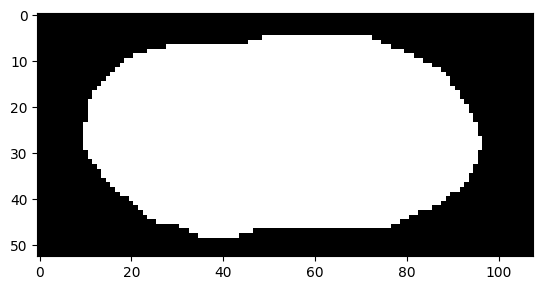

In [8]:
y0, x0 = centroid
a1 = int(x0 - major_axis_length * 0.6)
b1 = int(x0 + major_axis_length * 0.65)

a2 = int(y0 - minor_axis_length * 0.6)
b2 = int(y0 + minor_axis_length * 0.65)
import cv2

from PIL import Image

width, height = np.array(rotated_image)[a2:b2, a1:b1].shape

isolated_pn = np.array(rotated_image_orig)[a2:b2, a1:b1]

# upscaled_img = cv2.resize(rotated_image[a2:b2, a1:b1],
#                           None,
#                           fx=15,
#                           fy=15,
#                           interpolation=cv2.INTER_CUBIC)

# im = Image.fromarray(upscaled_img).resize((width, height),
#                                           resample=Image.LANCZOS)
smoothed_img = cv2.GaussianBlur(
    binary_dilation(rotated_image)[a2:b2, a1:b1].astype(np.uint8), (15, 15), 0)

plt.imshow(smoothed_img, cmap='gray')
plt.show()

# plt.imshow(rotated_image[a2:b2, a1:b1] > 10, cmap='gray')
# plt.show()

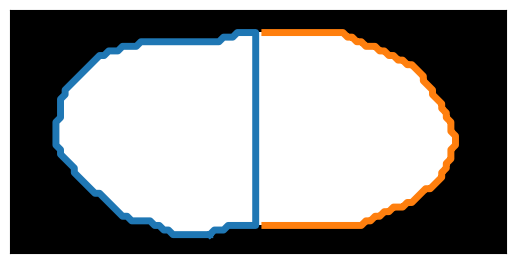

In [9]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import measure

# Construct some test data
# x, y = np.ogrid[-np.pi:np.pi:100j, -np.pi:np.pi:100j]
# r = np.sin(np.exp(np.sin(x)**3 + np.cos(y)**2))

# Find contours at a constant value of 0.8
contours = measure.find_contours(smoothed_img, None)

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(smoothed_img, cmap=plt.cm.gray)

for contour in contours:
    half_contour = contour[contour[:, 1] > smoothed_img.shape[1] // 2]

    half_contour1 = contour[contour[:, 1] < smoothed_img.shape[1] // 2]
    ax.plot(half_contour1[:, 1], half_contour1[:, 0], linewidth=5)
    ax.plot(half_contour[:, 1], half_contour[:, 0], linewidth=5)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [10]:
import numpy as np
import matplotlib.pyplot as plt


def fit_ellipse(x, y):
    A = np.stack([x**2, x * y, y**2, x, y]).T
    b = np.ones_like(x)

    return np.linalg.lstsq(A, b)[0].squeeze()


Fitted circle: center=(71.311, -26.104), radius=22.276
Fitted circle: center=(34.953, -26.060), radius=22.887


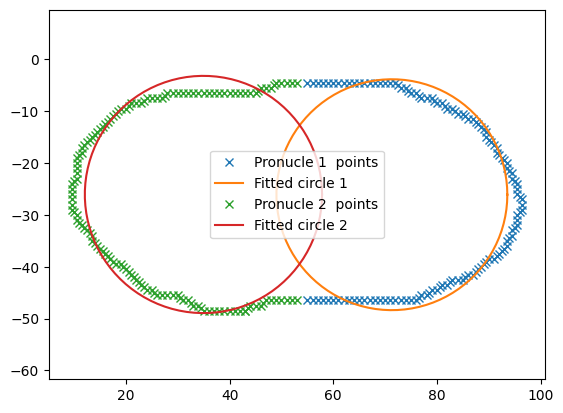

In [11]:
import numpy as np
import matplotlib.pyplot as plt


def fit_circle(x, y):
    """
    Fit a circle to the given x, y points using least squares.
    Returns the circle parameters: x0, y0 (center), and r (radius).
    """
    A = np.c_[2 * x, 2 * y, np.ones_like(x)]
    b = x**2 + y**2
    c = np.linalg.lstsq(A, b, rcond=None)[0]
    x0, y0 = c[0], c[1]
    r = np.sqrt(c[2] + x0**2 + y0**2)
    return x0, y0, r


def get_circle_pts(x0, y0, r, npts=100, tmin=0, tmax=2 * np.pi):
    """
    Return npts points on the circle defined by (x0, y0, r).
    """
    t = np.linspace(tmin, tmax, npts)
    x = x0 + r * np.cos(t)
    y = y0 + r * np.sin(t)
    return x, y


if __name__ == '__main__':
    # Example noisy circle
    np.random.seed(42)

    theta = np.linspace(0, 2 * np.pi, 100)
    x = half_contour[:, 1]
    y = -half_contour[:, 0]

    x0, y0, r = fit_circle(x, y)
    print(f"Fitted circle: center=({x0:.3f}, {y0:.3f}), radius={r:.3f}")

    xf, yf = get_circle_pts(x0, y0, r)

    plt.plot(x, y, 'x', label='Pronucle 1  points')
    plt.plot(xf, yf, '-', label='Fitted circle 1')
    plt.axis('equal')

    x = half_contour1[:, 1]
    y = -half_contour1[:, 0]

    x0, y0, r = fit_circle(x, y)
    print(f"Fitted circle: center=({x0:.3f}, {y0:.3f}), radius={r:.3f}")

    xf, yf = get_circle_pts(x0, y0, r)

    plt.plot(x, y, 'x', label='Pronucle 2  points')
    plt.plot(xf, yf, '-', label='Fitted circle 2')
    plt.axis('equal')
    plt.legend()
    plt.show()


Fitted circle 1: center=(71.311, -26.104), radius=22.276
Fitted circle 2: center=(34.953, -26.060), radius=22.887


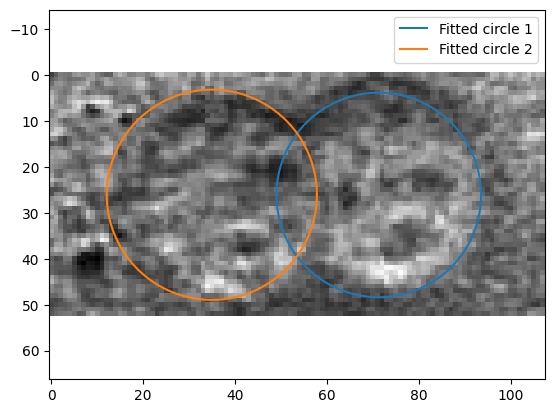

In [12]:
import numpy as np
import matplotlib.pyplot as plt

X0, Y0 = centroid


def fit_circle(x, y):
    A = np.c_[2 * x, 2 * y, np.ones_like(x)]
    b = x**2 + y**2
    c = np.linalg.lstsq(A, b, rcond=None)[0]
    x0, y0 = c[0], c[1]
    r = np.sqrt(c[2] + x0**2 + y0**2)
    return x0, y0, r


def get_circle_pts(x0, y0, r, npts=100, tmin=0, tmax=2 * np.pi):
    t = np.linspace(tmin, tmax, npts)
    x = x0 + r * np.cos(t)
    y = y0 + r * np.sin(t)
    return x, y


if __name__ == '__main__':
    # assume you already have isolated_pn, half_contour, and peakind defined
    fig, ax = plt.subplots()
    ax.imshow(isolated_pn, cmap='gray')  # show the image

    # First PN
    x = half_contour[:, 1]
    y = -half_contour[:, 0]
    x0, y0, r = fit_circle(x, y)
    print(f"Fitted circle 1: center=({x0:.3f}, {y0:.3f}), radius={r:.3f}")
    xf, yf = get_circle_pts(x0, -y0, r)
    # ax.plot(x, y, 'x', label='Pronucle 1 points')
    ax.plot(xf, yf, '-', label='Fitted circle 1')

    # Second PN
    x = half_contour1[:, 1]
    y = -half_contour1[:, 0]
    x0, y0, r = fit_circle(x, y)
    print(f"Fitted circle 2: center=({x0:.3f}, {y0:.3f}), radius={r:.3f}")
    xf, yf = get_circle_pts(x0, -y0, r)
    # ax.plot(x, y, 'x', label='Pronucle 2 points')
    ax.plot(xf, yf, '-', label='Fitted circle 2')
    # ax.plot(half_contour[:, 1], half_contour[:, 0], linewidth=5)

    ax.axis('equal')
    ax.legend()
    plt.show()
